# Sentiment Analyse Wissenschaft vs. Nicht-Wissenschaft

Verwendetes Modell: https://huggingface.co/cardiffnlp/twitter-xlm-roberta-base-sentiment

Notebook als Hilfestellung: https://github.com/amanabdullayev/tutorials/blob/main/01%20VADER%20vs%20Transformers%20for%20sentiment/vader_vs_transformers.ipynb

In [1]:
import pandas as pd
from transformers import pipeline
from tqdm import tqdm
import re

2024-04-07 08:12:58.341446: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Vorbereitung der Daten

In [2]:
tweets_wissenschaft = pd.read_excel('./data/tweets_wissenschaft.xlsx')
tweets_nichtwissenschaft = pd.read_excel('./data/tweets_nichtwissenschaft.xlsx')

In [3]:
def update_astype_tweets(df):
    df['tweet_text'] = df['tweet_text'].astype(str)
    df['tweet_text'] = df['tweet_text'].replace('-998', '')
    df['retweet_text_retweeted_tweet'] = df['retweet_text_retweeted_tweet'].astype(str)
    df['retweet_text_retweeted_tweet'] = df['retweet_text_retweeted_tweet'].replace('-998', '')
    df['zitat_text'] = df['zitat_text'].astype(str)
    df['zitat_text'] = df['zitat_text'].replace('-998', '')
    df['tweet_creator_bio'] = df['tweet_creator_bio'].astype(str)
    df['tweet_creator_bio'] = df['tweet_creator_bio'].replace('-998', '')
    df['tweet_creator_bio'] = df['tweet_creator_bio'].replace('nan', '')

In [4]:
update_astype_tweets(tweets_wissenschaft)
update_astype_tweets(tweets_nichtwissenschaft)

In [5]:
def preprocess(text):
    new_text = []
    for t in text.split(" "):
        t = '@user' if t.startswith('@') and len(t) > 1 else t
        t = 'http' if t.startswith('http') else t
        new_text.append(t)
    return " ".join(new_text)

In [6]:
for df in tweets_wissenschaft, tweets_nichtwissenschaft:
    df['tweet_text'] = df['tweet_text'].apply(preprocess)
    df['retweet_text_retweeted_tweet'] = df['retweet_text_retweeted_tweet'].apply(preprocess)
    df['zitat_text'] = df['zitat_text'].apply(preprocess)
    df['tweet_creator_bio'] = df['tweet_creator_bio'].apply(preprocess)

### Durchführung der Sentiment Analysen

In [7]:
from transformers import AutoModelForSequenceClassification
from transformers import AutoTokenizer, AutoConfig
from scipy.special import softmax
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import numpy as np
import torch
import torch.nn as nn

In [8]:
model_path = f"cardiffnlp/twitter-xlm-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(model_path)
config = AutoConfig.from_pretrained(model_path)
model = AutoModelForSequenceClassification.from_pretrained(model_path)

def sentiment_analyzer(text, model):
    if text.strip() == "":
        return None 
    else:
        encoded_input = tokenizer(text, return_tensors="pt")
        output = model(**encoded_input)
        scores = output[0][0].detach().numpy()
        scores = np.round(softmax(scores), 2)
        scores_dict = {"neg": scores[0], "neu": scores[1], "pos": scores[2]}
        return scores_dict

In [9]:
tqdm.pandas() 

In [10]:
def get_sentiments(df, columns):
    for column in columns:
        df["probabilities"] = df[column].progress_apply(sentiment_analyzer, model=model)
        probabilities = df["probabilities"].apply(pd.Series)
        df = df.join(probabilities)
        df = df.drop("probabilities", axis=1)
    
        polarity_weights = torch.tensor([-1, 0, 1])
        probs = torch.tensor(df[["neg", "neu", "pos"]].values)
        polarity = polarity_weights * probs
        polarity = polarity.sum(dim=-1)
        polarity_scaled = nn.Tanh()(polarity)
    
        df[f"{column}_polarity"] = polarity_scaled.numpy()
        df[f"{column}_sentiment"] = pd.cut(df[f"{column}_polarity"],
                                     bins=[-1.0, -0.25, 0.25, 1.0],
                                     labels=["Negative", "Neutral", "Positive"],
                                    )
        df = df.drop(["neu", "neg", "pos"], axis=1)
    return df

In [11]:
tweets_wissenschaft_sentiment = get_sentiments(tweets_wissenschaft,['tweet_text','retweet_text_retweeted_tweet', 'zitat_text'])
tweets_wissenschaft_sentiment.head()

100%|██████████| 3749/3749 [03:39<00:00, 17.05it/s]


,tweet_date_create,tweet_creator_atName,tweet_creator_screenName,tweet_creator_bio,tweet_text,retweet_text_retweeted_tweet,zitat_text,gender,institution,author_category,tweet_text_polarity,tweet_text_sentiment,retweet_text_retweeted_tweet_polarity,retweet_text_retweeted_tweet_sentiment,zitat_text_polarity,zitat_text_sentiment
0,2022-12-14 20:27:18,olewin,@olewin@mastodon.social 🇪🇺,Earthling of European origin. #Nachhaltigkeit ...,"Die Politikerin @user schätzt, dass wir in 10 ...",,Auch Deutschland habe Stärken in der Kernfusio...,männlich,Person,wissenschaftsnah,0.010000,Neutral,NaN,NaN,0.254296,Positive
1,2022-12-14 20:44:13,CorinnaEhlers,Corinna Ehlers (corinnaehlers@openbiblio.social),Grenzgängerin Theologie/Bibliothekswesen im FI...,,Forschungsstipendien an der Reformationsgeschi...,,weiblich,Person,Wissenschaftler*in,NaN,NaN,0.039979,Neutral,NaN,NaN
2,2022-12-14 21:01:37,t3pad,Sonnen-τau (he/him),"Wer nur auf mein Gendern eingeht, hat offensic...",,Kernfusion ist keine Lösung in der Klimakrise ...,,männlich,Person,wissenschaftsnah,NaN,NaN,-0.139092,Neutral,NaN,NaN
3,2022-12-14 21:20:53,uehackler,U.E. Hackler🇩🇪🇯🇵🇺🇸,"Ph.D. in Chemistry, Languages: German, English...",,Der sensationelle Erfolg der USA bei der #Kern...,,männlich,Person,Wissenschaftler*in,NaN,NaN,0.413644,Positive,NaN,NaN
4,2022-12-14 21:28:53,agriachim,Achim Spiller,Professor Lebensmittel- u. Agrarmarketing Uni ...,Beide waren tolle Partner im Bioweiderindproje...,,Die Erzeugergemeinschaft Schwarzwald Bio-#Weid...,männlich,Person,Wissenschaftler*in,0.362707,Positive,NaN,NaN,0.069886,Neutral


In [12]:
tweets_nichtwissenschaft_sentiment = get_sentiments(tweets_nichtwissenschaft,['tweet_text','retweet_text_retweeted_tweet', 'zitat_text'])
tweets_nichtwissenschaft_sentiment.head()

100%|██████████| 21965/21965 [20:40<00:00, 17.71it/s]   


,tweet_date_create,tweet_creator_atName,tweet_creator_screenName,tweet_creator_bio,tweet_text,retweet_text_retweeted_tweet,zitat_text,gender,institution,author_category,tweet_text_polarity,tweet_text_sentiment,retweet_text_retweeted_tweet_polarity,retweet_text_retweeted_tweet_sentiment,zitat_text_polarity,zitat_text_sentiment
0,2022-12-14 20:19:48,SuchtiSchleich,Steffk,,,"Es scheint so weit weg, so surreal, aber es fe...",,männlich,Person,unklar,NaN,NaN,-0.691069,Negative,NaN,NaN
1,2022-12-14 20:20:26,printi71,printi007 aka Dr. Canceloretta,😷 Infektionsverweigerin,,@user @user #KleinschnitzRausschmiss sofort @u...,#KleinschnitzRausschmiss bitte jetzt @user @us...,weiblich,Person,unklar,NaN,NaN,0.000000,Neutral,-0.658409,Negative
2,2022-12-14 20:20:34,4linblue1,4linblue🔱,Wenn ein Kopf und ein Buch zusammen stoßen und...,@user @user Hier in der Familie hat jeder Erfa...,,,unklar,unklar,unklar,0.089758,Neutral,NaN,NaN,NaN,NaN
3,2022-12-14 20:21:01,HartwigKmmerle,Ho finito!,"+ jedem Anfang wohnt ein Zauber inne, der uns ...",,Forschung an einem faszinierenden Potenzialthe...,,männlich,Person,unklar,NaN,NaN,-0.578363,Negative,NaN,NaN
4,2022-12-14 20:21:11,printi71,printi007 aka Dr. Canceloretta,😷 Infektionsverweigerin,,#KleinschnitzRausschmiss sollte trenden!,#KleinschnitzRausschmiss bitte jetzt @user @us...,weiblich,Person,unklar,NaN,NaN,0.139092,Neutral,-0.658409,Negative


In [13]:
tweets_wissenschaft_sentiment.to_excel('./sentiment_data/tweets_wissenschaft_sentiment.xlsx')
tweets_nichtwissenschaft_sentiment.to_excel('./sentiment_data/tweets_nichtwissenschaft_sentiment.xlsx')

### Gegenüberstellung der Ergebnisse

In [1]:
import pandas as pd

In [2]:
tweets_wissenschaft_sentiment = pd.read_excel('./sentiment_data/tweets_wissenschaft_sentiment.xlsx')
tweets_nichtwissenschaft_sentiment = pd.read_excel('./sentiment_data/tweets_nichtwissenschaft_sentiment.xlsx')

In [3]:
# Definieren der Spalten, die Sentiment-Daten enthalten
sentiment_columns = ['tweet_text_sentiment', 'retweet_text_retweeted_tweet_sentiment', 'zitat_text_sentiment']

#### Überblick Ergebnisse - Wissenschaft

In [4]:
value_counts = []
percentages = []
for column in sentiment_columns:
    vc = tweets_wissenschaft_sentiment[column].value_counts()
    pct = vc / vc.sum() * 100  # Optimiert: Verwende vc zur Berechnung von pct
    value_counts.append(vc)
    percentages.append(pct.round(2))  # Runden direkt nach der Berechnung

# DataFrames aus den Value Counts und Prozenten
counts_wissenschaft = pd.DataFrame(value_counts)
percentages_wissenschaft = pd.DataFrame(percentages)

# Setzen der Indizes
counts_wissenschaft.index = percentages_wissenschaft.index = sentiment_columns

# Hinzufügen der 'all_tweets' Zeile zur Zusammenfassung über alle Tweets
counts_wissenschaft.loc['all_tweets'] = counts_wissenschaft.sum()
percentages_wissenschaft.loc['all_tweets'] = (counts_wissenschaft.loc['all_tweets'] / counts_wissenschaft.loc['all_tweets'].sum() * 100).round(2)

In [5]:
#Reihenfolge Spalten ändern
counts_wissenschaft = counts_wissenschaft[['Negative', 'Neutral', 'Positive']]
percentages_wissenschaft = percentages_wissenschaft[['Negative', 'Neutral', 'Positive']]

In [6]:
counts_wissenschaft

,Negative,Neutral,Positive
tweet_text_sentiment,555,786,453
retweet_text_retweeted_tweet_sentiment,500,928,527
zitat_text_sentiment,163,493,208
all_tweets,1218,2207,1188


In [7]:
percentages_wissenschaft

,Negative,Neutral,Positive
tweet_text_sentiment,30.94,43.81,25.25
retweet_text_retweeted_tweet_sentiment,25.58,47.47,26.96
zitat_text_sentiment,18.87,57.06,24.07
all_tweets,26.40,47.84,25.75


#### Überblick Ergebnisse - Nichtwissenschaft

In [8]:
value_counts = []
percentages = []
for column in sentiment_columns:
    vc = tweets_nichtwissenschaft_sentiment[column].value_counts()
    pct = vc / vc.sum() * 100  # Optimiert: Verwende vc zur Berechnung von pct
    value_counts.append(vc)
    percentages.append(pct.round(2))  # Runden direkt nach der Berechnung

# DataFrames aus den Value Counts und Prozenten
counts_nichtwissenschaft = pd.DataFrame(value_counts)
percentages_nichtwissenschaft = pd.DataFrame(percentages)

# Setzen der Indizes
counts_nichtwissenschaft.index = percentages_nichtwissenschaft.index = sentiment_columns

# Hinzufügen der 'all_tweets' Zeile zur Zusammenfassung über alle Tweets
counts_nichtwissenschaft.loc['all_tweets'] = counts_nichtwissenschaft.sum()
percentages_nichtwissenschaft.loc['all_tweets'] = (counts_nichtwissenschaft.loc['all_tweets'] / counts_nichtwissenschaft.loc['all_tweets'].sum() * 100).round(2)

In [9]:
counts_nichtwissenschaft

,Negative,Neutral,Positive
tweet_text_sentiment,3842,3676,1164
retweet_text_retweeted_tweet_sentiment,6097,5067,2119
zitat_text_sentiment,1393,2344,743
all_tweets,11332,11087,4026


In [10]:
percentages_nichtwissenschaft

,Negative,Neutral,Positive
tweet_text_sentiment,44.25,42.34,13.41
retweet_text_retweeted_tweet_sentiment,45.90,38.15,15.95
zitat_text_sentiment,31.09,52.32,16.58
all_tweets,42.85,41.92,15.22


#### Analyse über Zeitverlauf

In [43]:
df = tweets_wissenschaft_sentiment.copy()

# Datum in datetime umwandeln und Jahr-Monat extrahieren
df['tweet_date_create'] = pd.to_datetime(df['tweet_date_create'])
df['year_week'] = df['tweet_date_create'].dt.to_period('W')

# Alle Sentiments in einer einzigen Spalte zusammenführen
all_sentiments = pd.concat([
    df['tweet_text_sentiment'],
    df['retweet_text_retweeted_tweet_sentiment'],
    df['zitat_text_sentiment']
], ignore_index=True)

# Zugehörige Datumswerte für die zusammengeführten Sentiments wiederholen
dates = pd.concat([df['year_week']] * 3, ignore_index=True)

# Neuen DataFrame erstellen für die Analyse
combined = pd.DataFrame({
    'year_week': dates,
    'sentiment': all_sentiments
})

# Sentiments nach Jahr und Monat gruppieren und zählen
weekly_sentiment_wissenschaft_counts = combined.groupby(['year_week', 'sentiment']).size().unstack(fill_value=0)

# Format der Wochenbezeichnung anpassen: 'KWxx, yyyy'
weekly_sentiment_wissenschaft_counts.index = weekly_sentiment_wissenschaft_counts.index.to_series().apply(lambda x: f'KW{x.week}/ {x.start_time.year}')

# Prozentuale Anteile berechnen
weekly_sentiment_wissenschaft_percentages  = weekly_sentiment_wissenschaft_counts .div(weekly_sentiment_wissenschaft_counts .sum(axis=1), axis=0) * 100

In [44]:
weekly_sentiment_wissenschaft_counts

sentiment,Negative,Neutral,Positive
year_week,,,
KW50/ 2022,88,154,90
KW51/ 2022,68,170,122
KW52/ 2022,78,89,42
KW1/ 2023,111,193,120
KW2/ 2023,253,351,153
KW3/ 2023,154,323,132
KW4/ 2023,160,264,158
KW5/ 2023,197,347,201
KW6/ 2023,109,315,169


In [45]:
# Letze Zeile entfernen wegen zu geringer Anzahl
weekly_sentiment_wissenschaft_counts = weekly_sentiment_wissenschaft_counts.drop(['KW7/ 2023'], axis=0)
weekly_sentiment_wissenschaft_percentages = weekly_sentiment_wissenschaft_percentages.drop(['KW7/ 2023'], axis=0)

In [46]:
weekly_sentiment_wissenschaft_counts

sentiment,Negative,Neutral,Positive
year_week,,,
KW50/ 2022,88,154,90
KW51/ 2022,68,170,122
KW52/ 2022,78,89,42
KW1/ 2023,111,193,120
KW2/ 2023,253,351,153
KW3/ 2023,154,323,132
KW4/ 2023,160,264,158
KW5/ 2023,197,347,201
KW6/ 2023,109,315,169


In [47]:
weekly_sentiment_wissenschaft_percentages

sentiment,Negative,Neutral,Positive
year_week,,,
KW50/ 2022,26.506024,46.385542,27.108434
KW51/ 2022,18.888889,47.222222,33.888889
KW52/ 2022,37.320574,42.583732,20.095694
KW1/ 2023,26.179245,45.518868,28.301887
KW2/ 2023,33.421400,46.367239,20.211361
KW3/ 2023,25.287356,53.037767,21.674877
KW4/ 2023,27.491409,45.360825,27.147766
KW5/ 2023,26.442953,46.577181,26.979866
KW6/ 2023,18.381113,53.119730,28.499157


In [60]:
df = tweets_nichtwissenschaft_sentiment.copy()

# Datum in datetime umwandeln und Jahr-Monat extrahieren
df['tweet_date_create'] = pd.to_datetime(df['tweet_date_create'])
df['year_week'] = df['tweet_date_create'].dt.to_period('W')

# Alle Sentiments in einer einzigen Spalte zusammenführen
all_sentiments = pd.concat([
    df['tweet_text_sentiment'],
    df['retweet_text_retweeted_tweet_sentiment'],
    df['zitat_text_sentiment']
], ignore_index=True)

# Zugehörige Datumswerte für die zusammengeführten Sentiments wiederholen
dates = pd.concat([df['year_week']] * 3, ignore_index=True)

# Neuen DataFrame erstellen für die Analyse
combined = pd.DataFrame({
    'year_week': dates,
    'sentiment': all_sentiments
})

# Sentiments nach Jahr und Monat gruppieren und zählen
weekly_sentiment_nichtwissenschaft_counts = combined.groupby(['year_week', 'sentiment']).size().unstack(fill_value=0)

# Format der Wochenbezeichnung anpassen: 'KWxx, yyyy'
weekly_sentiment_nichtwissenschaft_counts.index = weekly_sentiment_nichtwissenschaft_counts.index.to_series().apply(lambda x: f'KW{x.week}/ {x.start_time.year}')

# Prozentuale Anteile berechnen
weekly_sentiment_nichtwissenschaft_percentages  = weekly_sentiment_nichtwissenschaft_counts .div(weekly_sentiment_nichtwissenschaft_counts .sum(axis=1), axis=0) * 100

In [61]:
weekly_sentiment_nichtwissenschaft_counts

sentiment,Negative,Neutral,Positive
year_week,,,
KW50/ 2022,873,601,261
KW51/ 2022,700,750,302
KW52/ 2022,870,749,184
KW1/ 2023,953,777,321
KW2/ 2023,1724,2240,847
KW3/ 2023,1835,1713,428
KW4/ 2023,1514,1832,409
KW5/ 2023,1670,1241,634
KW6/ 2023,1187,1171,634


In [62]:
# Letze Zeile entfernen wegen zu geringer Anzahl
weekly_sentiment_nichtwissenschaft_counts = weekly_sentiment_nichtwissenschaft_counts.drop(['KW7/ 2023'], axis=0)
weekly_sentiment_nichtwissenschaft_percentages = weekly_sentiment_nichtwissenschaft_percentages.drop(['KW7/ 2023'], axis=0)

In [63]:
weekly_sentiment_nichtwissenschaft_counts

sentiment,Negative,Neutral,Positive
year_week,,,
KW50/ 2022,873,601,261
KW51/ 2022,700,750,302
KW52/ 2022,870,749,184
KW1/ 2023,953,777,321
KW2/ 2023,1724,2240,847
KW3/ 2023,1835,1713,428
KW4/ 2023,1514,1832,409
KW5/ 2023,1670,1241,634
KW6/ 2023,1187,1171,634


In [64]:
weekly_sentiment_nichtwissenschaft_percentages

sentiment,Negative,Neutral,Positive
year_week,,,
KW50/ 2022,50.317003,34.639769,15.043228
KW51/ 2022,39.954338,42.808219,17.237443
KW52/ 2022,48.252912,41.541875,10.205214
KW1/ 2023,46.465139,37.883959,15.650902
KW2/ 2023,35.834546,46.559967,17.605487
KW3/ 2023,46.151911,43.083501,10.764588
KW4/ 2023,40.319574,48.788282,10.892144
KW5/ 2023,47.108604,35.007052,17.884344
KW6/ 2023,39.672460,39.137701,21.189840


#### Visualisieren der Ergebnisse

In [53]:
import matplotlib.pyplot as plt
colors = ['firebrick','bisque','forestgreen']

##### Sentiment Verteilungen

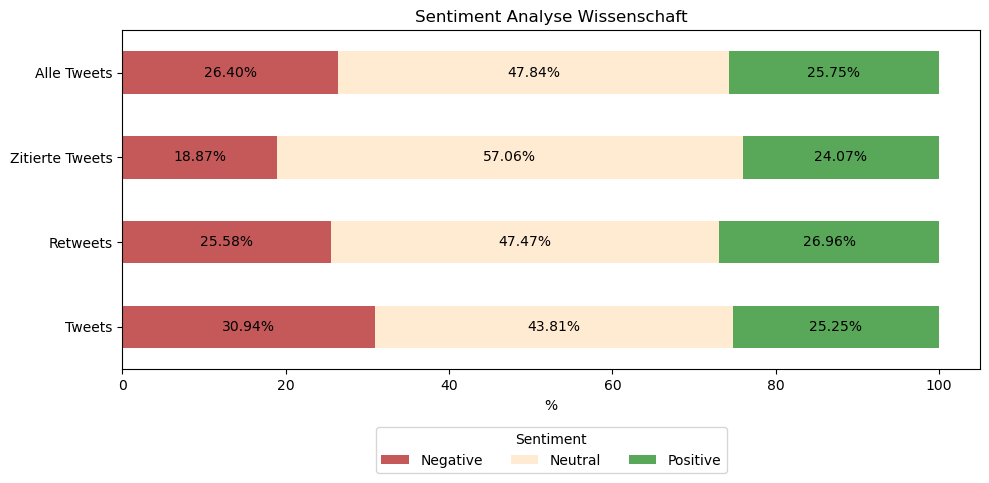

In [54]:
# Gestapeltes Balkendiagramm erstellen
ax = percentages_wissenschaft.plot(kind='barh', stacked=True, figsize=(10, 5), color=colors, alpha=0.75)
ax.set_xlabel('%')
ax.set_title('Sentiment Analyse Wissenschaft')
ax.set_yticklabels(['Tweets','Retweets','Zitierte Tweets', 'Alle Tweets'])

# Balkenbeschriftungen hinzufügen
for n in ax.patches:
    left, bottom, width, height = n.get_bbox().bounds
    ax.annotate(f"{width:.2f}%", xy=(left+width/2, bottom+height/2), 
                ha='center', va='center', fontsize=10, color='black')
    
plt.legend(title='Sentiment', bbox_to_anchor=(0.5, -0.15), loc='upper center', ncol=3)
plt.tight_layout()
plt.show()

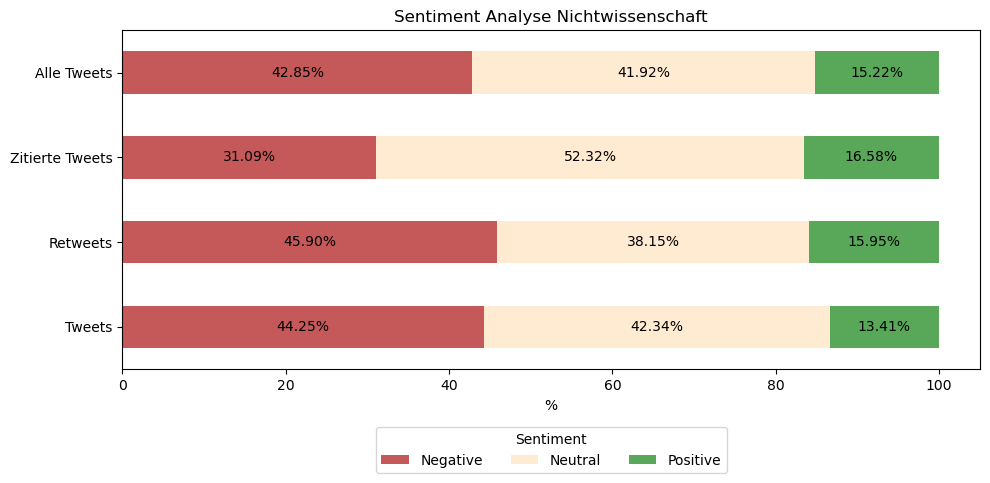

In [55]:
# Gestapeltes Balkendiagramm erstellen
ax = percentages_nichtwissenschaft.plot(kind='barh', stacked=True, figsize=(10, 5), color=colors, alpha=0.75)
ax.set_xlabel('%')
ax.set_title('Sentiment Analyse Nichtwissenschaft')
ax.set_yticklabels(['Tweets','Retweets','Zitierte Tweets', 'Alle Tweets'])

# Balkenbeschriftungen hinzufügen
for n in ax.patches:
    left, bottom, width, height = n.get_bbox().bounds
    ax.annotate(f"{width:.2f}%", xy=(left+width/2, bottom+height/2), 
                ha='center', va='center', fontsize=10, color='black')
    
plt.legend(title='Sentiment', bbox_to_anchor=(0.5, -0.15), loc='upper center', ncol=3)
plt.tight_layout()
plt.show()

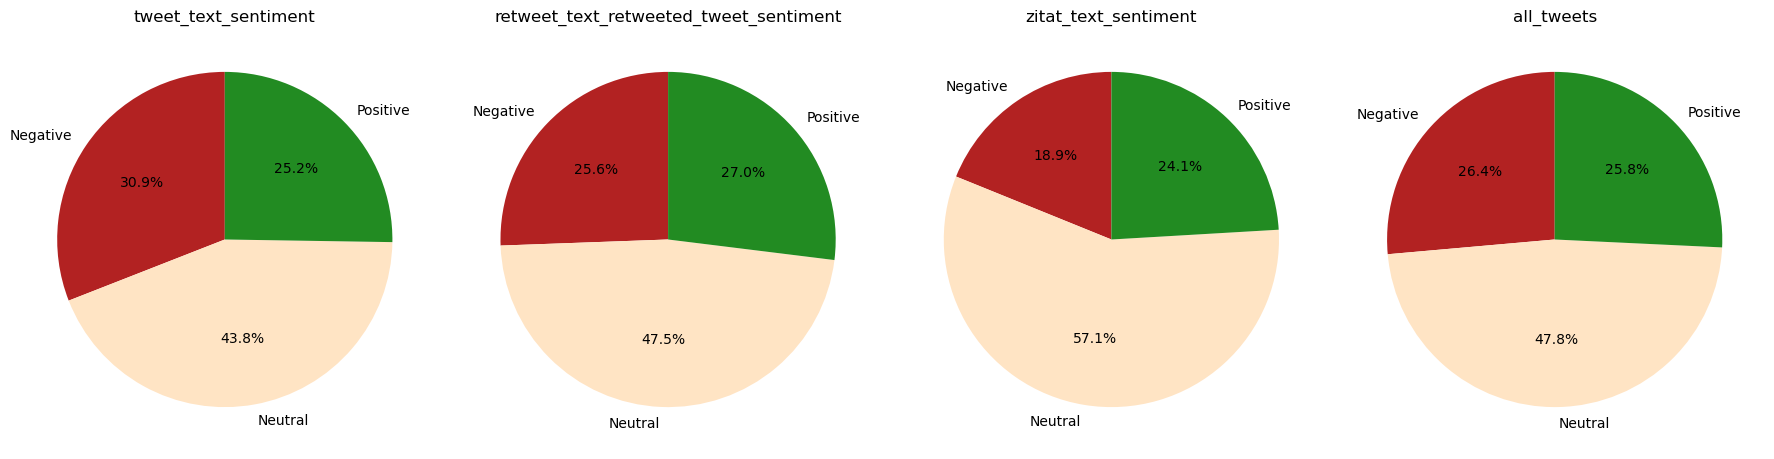

In [56]:
# Kreisdiagramme für jede Kategorie erstellenx
fig, axes = plt.subplots(1, 4, figsize=(18, 6))

for i, (idx, row) in enumerate(percentages_wissenschaft.iterrows()):
    ax = axes[i]
    ax.pie(row, labels=row.index, autopct='%1.1f%%', startangle=90, colors=colors)
    ax.set_title(idx)

plt.tight_layout()
plt.show()

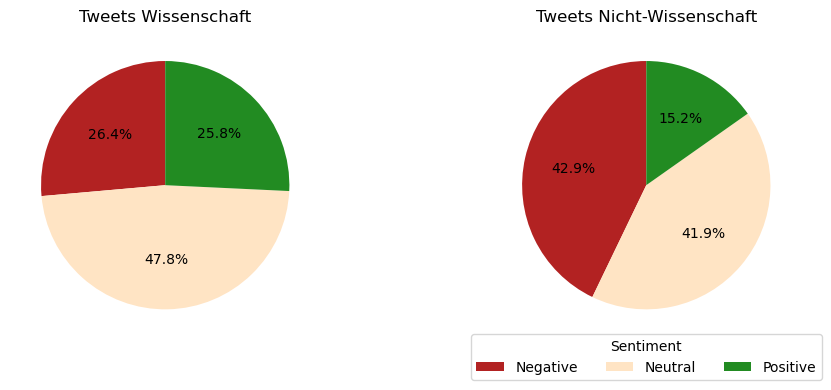

In [57]:
# Erstellen der Plots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))  # Zwei Plots nebeneinander

# Erstes Kreisdiagramm
axes[0].pie(counts_wissenschaft.loc['all_tweets'], autopct='%1.1f%%', startangle=90, colors=colors)
axes[0].set_title('Tweets Wissenschaft')

# Zweites Kreisdiagramm
axes[1].pie(counts_nichtwissenschaft.loc['all_tweets'], autopct='%1.1f%%', startangle=90, colors=colors)
axes[1].set_title('Tweets Nicht-Wissenschaft')

# Anzeigen der Plots
plt.legend(labels = row.index, title='Sentiment', bbox_to_anchor=(0.5, -0.15), loc=8, ncol=3)
plt.tight_layout() 
plt.show()

##### Zeitlicher Verlauf

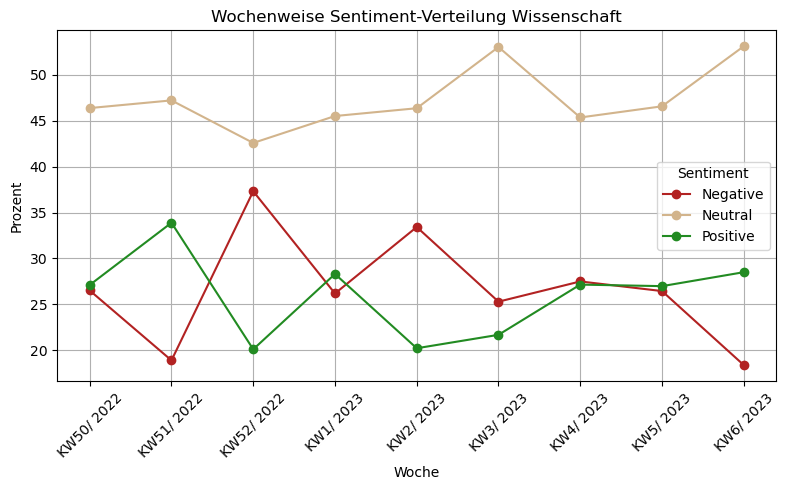

In [67]:
# Liniendiagramm der Sentiment-Verteilung pro Woche für Datensatz Wissenschaft
colors = ['firebrick','tan','forestgreen']
weekly_sentiment_wissenschaft_percentages.plot(kind='line', marker='o', figsize=(8, 5), color=colors)
plt.title('Wochenweise Sentiment-Verteilung Wissenschaft')
plt.xlabel('Woche')
plt.ylabel('Prozent')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()  
plt.legend(title='Sentiment')
plt.show()

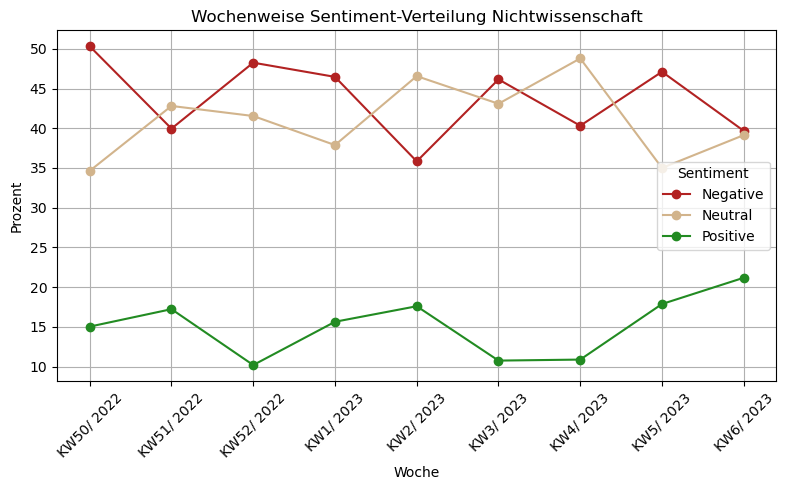

In [76]:
# Liniendiagramm der Sentiment-Verteilung pro Woche für Datensatz Nichtwissenschaft
colors = ['firebrick','tan','forestgreen']
weekly_sentiment_nichtwissenschaft_percentages.plot(kind='line', marker='o', figsize=(8, 5), color=colors)
plt.title('Wochenweise Sentiment-Verteilung Nichtwissenschaft')
plt.xlabel('Woche')
plt.ylabel('Prozent')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()  
plt.legend(title='Sentiment', loc= 5)
plt.show()